In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

Load data - from image version

In [2]:
class PixelDataset(Dataset):
    def __init__(self, photo_path, highlighted_path):
        photo = np.array(Image.open(photo_path)) / 255.0
        highlighted = np.array(Image.open(highlighted_path))[:, :, 0:1] / 255.0
        assert photo.shape[:2] == highlighted.shape[:2]
        self.photo = np.einsum('ijk->kij', photo.astype(np.float32))
        self.highlighted = highlighted.astype(np.float32)
        self.shape = photo.shape[:2]
        self.size = 33
        self.skip = 2
        self.grid = (
            (self.shape[0]-self.size)//self.skip,
            (self.shape[1]-self.size)//self.skip
        )

    def __len__(self):
        return self.grid[0] * self.grid[1]
    
    def __getitem__(self, i):
        i, j = self.skip * i // self.grid[1], self.skip * i % self.grid[1]
        return [
            self.photo[:, i:i+self.size, j:j+self.size],
            self.highlighted[i+self.size//2, j+self.size//2]
        ]

dataset = PixelDataset("nurdles_train.jpg", "nurdles_train.png")
for nin, nout in DataLoader(
    dataset,
    batch_size=16,
    shuffle=True
):
    print(nin.dtype, nout.dtype)
    print(nin.shape, nout.shape)
    break

torch.float32 torch.float32
torch.Size([16, 3, 33, 33]) torch.Size([16, 1])


Load data - from raw version

torch.float32 torch.Size([36, 3, 49, 49])
torch.float32 torch.Size([36, 1])
tensor([[0.0000, 0.0039, 0.0039, 0.0000, 0.0000, 0.0000],
        [0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0039, 0.0000, 0.6784, 0.0000, 0.0039, 0.0000],
        [0.0000, 0.0039, 0.0000, 0.0039, 0.0000, 0.0039],
        [0.0000, 0.0039, 0.0000, 1.0000, 0.0000, 0.0000]])


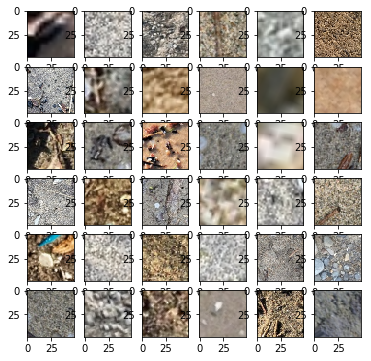

In [13]:
class RawDataset(Dataset):
    def __init__(self):
        s = 49
        self.imgin = np.fromfile("images/data_in.raw", dtype=np.uint8)
        self.imgin = self.imgin.reshape((len(self.imgin)//(3*s*s), 3, s, s))
        self.imgout = np.fromfile("images/data_out.raw", dtype=np.uint8)
        self.size = s

    def __len__(self):
        nin = self.imgin.shape[0]
        nout = len(self.imgout)
        assert nin == nout
        return nin

    def __getitem__(self, i):
        return [
            self.imgin[i].astype(np.float32) / 255.0,
            self.imgout[i:i+1].astype(np.float32) / 255.0
        ]

dataset = RawDataset()
for imgin, imgout in DataLoader(
    dataset,
    batch_size=36,
    shuffle=True
):
    print(imgin.dtype, imgin.shape)
    print(imgout.dtype, imgout.shape)
    n = int(imgin.shape[0]**0.5)

    imgout = imgout.reshape((n, n))
    print(imgout)

    imgin = np.einsum('acij->aijc', imgin.numpy())

    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(imgin[i])

    plt.show()
    break

Model

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        n = 4
        model = [
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 33x33
            nn.Conv2d(3, n, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        for _ in range(10):
            model += [
                nn.Conv2d(n, n, 3, 1, 0, bias=False),
                nn.ZeroPad2d(-1),
                nn.BatchNorm2d(n),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        model += [
            # 3 x 5x5
            nn.Conv2d(n, 1, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            # 1 x 1x1
            nn.Sigmoid()
        ]
        self.main = nn.Sequential(*model)
    
    def forward(self, x):
        return self.main(x)

model = Model()
print(model)

Model(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(4, 4, kerne

Training

In [15]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005, betas=(0.9, 0.999))


lossFun = torch.nn.BCELoss()
flatten = torch.nn.Flatten()

print("ADAM")
count = 0
for epoch in range(1, 5+1):
    print("Epoch", epoch)
    for nin, nout in dataloader:
        optimizer.zero_grad()
        output = flatten(model(nin))
        loss = lossFun(output, nout)
        loss.backward()
        optimizer.step()
        
        count += 1
        if count % 200 == 0:
            print("Iteration {} - loss = {}".format(count, loss.item()))

ADAM
Epoch 1
Iteration 200 - loss = 0.1851060539484024
Iteration 400 - loss = 0.2357165515422821
Iteration 600 - loss = 0.25030139088630676
Iteration 800 - loss = 0.16724473237991333
Iteration 1000 - loss = 0.10023511946201324
Iteration 1200 - loss = 0.17419736087322235
Iteration 1400 - loss = 0.25128495693206787
Iteration 1600 - loss = 0.10517190396785736
Epoch 2
Iteration 1800 - loss = 0.2511109411716461
Iteration 2000 - loss = 0.11144675314426422
Iteration 2200 - loss = 0.13375674188137054
Iteration 2400 - loss = 0.19448313117027283
Iteration 2600 - loss = 0.08816345781087875
Iteration 2800 - loss = 0.16437624394893646
Iteration 3000 - loss = 0.045617833733558655
Iteration 3200 - loss = 0.05497291684150696
Iteration 3400 - loss = 0.2520647644996643
Epoch 3
Iteration 3600 - loss = 0.08634573966264725
Iteration 3800 - loss = 0.153476744890213
Iteration 4000 - loss = 0.04049265757203102
Iteration 4200 - loss = 0.37477123737335205
Iteration 4400 - loss = 0.10510772466659546
Iteration 46

Calculate running mean and variance

In [16]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True
))

for nin, nout in dataloader:
    with torch.no_grad():
        output = flatten(model(nin))
        loss = lossFun(output, nout)
        print(loss)

tensor(0.1125)


Export

In [17]:
import os
os.system("rm weights/*")

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{:02d}{}".format(bn_i//2, bn_i%2)
        bns.append((name, data))
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    data.numpy().astype(np.float32).tofile("weights/"+name+".bin")
    param_i += 1

bn_i = 0
for layer in model.main:
    if layer.__class__.__name__ != "BatchNorm2d":
        continue
    layer.track_running_stats = False  # freeze
    mu = layer.running_mean
    var = layer.running_var
    name = "bn{:02d}2".format(bn_i)
    bns.append((name, mu))
    name = "bn{:02d}3".format(bn_i)
    bns.append((name, var))
    bn_i += 1

bns.sort()
for name, data in bns:
    s = '[' + ', '.join(map(str, data.numpy())) + ']'
    print(f"{name}: {s},")

bn000: [0.9949262, 0.5413715, 1.3268206],
bn001: [0.43789864, -1.0724871, 0.23723772],
bn002: [0.58713067, 0.54704195, 0.4980869],
bn003: [0.031449087, 0.030002294, 0.031490255],
bn010: [1.438268, 0.8445165, 0.9577803, 1.3784257],
bn011: [-0.18400161, 0.03448458, -0.30167732, 0.5970172],
bn012: [0.4148279, 0.31606364, -2.594129, -0.6024124],
bn013: [3.2921517, 2.1032813, 4.4007998, 3.0446515],
bn020: [1.0380269, 1.4881246, 1.0365529, 0.7419087],
bn021: [0.61858356, -0.0055373395, -0.04603948, -0.38264126],
bn022: [-3.5692205, -1.5840508, 2.1315477, 3.1615915],
bn023: [30.49014, 8.102305, 12.673951, 18.614273],
bn030: [1.287607, 0.8935229, 1.4563013, 0.7679142],
bn031: [-0.12747325, 0.49525473, -0.41412106, -0.10013982],
bn032: [-0.14555849, 1.6480919, -0.32990727, -0.3174804],
bn033: [1.8569512, 9.277503, 2.7103086, 2.834343],
bn040: [0.68091863, 0.42329478, 1.1264807, 1.2286702],
bn041: [-0.38466516, -0.46899262, -0.7990608, 0.32281545],
bn042: [0.34280092, -2.6828628, 2.3720944, -0.6

https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

In [18]:
import torch.onnx

x = torch.randn(1, 3, dataset.size, dataset.size, requires_grad=True)
torch_out = model(x)

torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

Visualize

In [ ]:
photo = np.array(Image.open("nurdles_test.jpg")) / 255.0
plt.imshow(photo)
plt.show()
photo = np.einsum('ijk->kij', photo.astype(np.float32))
photo = torch.tensor([photo])

print(photo.shape)
with torch.no_grad():
    output = model(photo)
    output = np.array(output)[0][0]
print(output.shape)
output = np.einsum('kij->ijk', [output, output, output])
output = (255.0*output).astype(np.uint8)
plt.imshow(output)
plt.show()

size = dataset.size
skip = 6
frames = []
for i in range(0, photo.shape[2]-size, skip):
    for j in range(0, photo.shape[3]-size, skip):
        frames.append(photo[:, :, i:i+size, j:j+size][0].numpy())
ni = len(range(0, photo.shape[2]-size, skip))
nj = len(range(0, photo.shape[3]-size, skip))
with torch.no_grad():
    frames = torch.tensor(frames)
    print(frames.shape)

    from time import perf_counter
    t0 = perf_counter()
    output = model(frames)
    t1 = perf_counter()
    print(t1-t0, "secs")

    print(output.shape)
    output = np.array(output).reshape((ni, nj))
output = (255.0*output).astype(np.uint8)
plt.imshow(output)
plt.show()